#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import time 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
#from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

from scipy.stats import boxcox 

# Константы
RANDOM_STATE = 12345

In [2]:
data = pd.read_csv('...',index_col=[0], parse_dates=[0])
data.head(3)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28


In [3]:
print(data.index.min())
print(data.index.max())

2018-03-01 00:00:00
2018-08-31 23:50:00


Видм, что таблица состоит из поля num_orders, индексируется по датам и содержит данные с 1марта по 31 декабря 2018года.
<br>Переименование колонок не требуется.

In [4]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


Исправление типов данных не требуется.
<br>Проверим монотонность(упорядоченность) индекса.

In [5]:
print(data.index.is_monotonic)

True


Индекс упорядоченный, дополнительных действий не требуется.
<br> Проверим таблицу на пропуски значений.

In [6]:
data[data['num_orders'].isna()]

,num_orders
datetime,


Пропусков в таблице нет.
<br>Проверим индекс на дубликаты (поверять колонку num_orders на дубликаты не имеет смысла, так как по смыслу они возможны и допустимы).

In [7]:
data[data.index.duplicated()]

,num_orders
datetime,


**Вывод:**
- Таблица состоит из поля num_orders, индексируется по датам и содержит данные с 1марта по 31 декабря 2018года.
- Переименование колонок не требуется
- Исправление типов данных не требуется
- Индекс упорядоченный
- Пропущенных значений нет
- Дубликатов по индексу нет

## Анализ

### Общий анализ

Посмотрим описательную статистику по показателю num_orders.

In [8]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [9]:
data[data['num_orders']==119]

,num_orders
datetime,
2018-08-13 02:20:00,119
2018-08-27 02:10:00,119


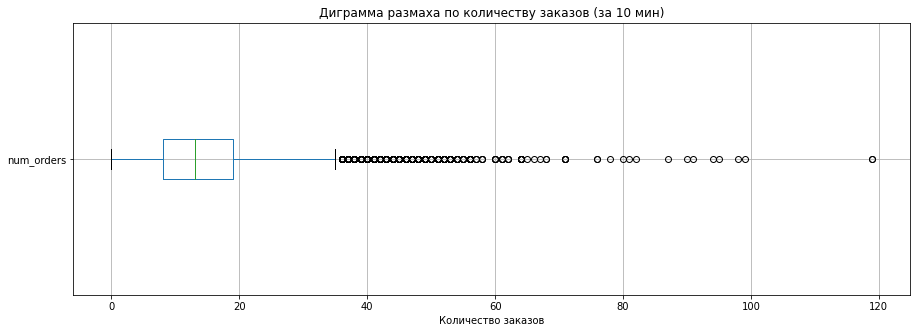

In [10]:
plt.figure(figsize=(15, 5))
data.boxplot(vert=0)
plt.title('Диграмма размаха по количеству заказов (за 10 мин)')
plt.xlabel('Количество заказов')
plt.show()

- Среденее количество заказов - 14 заказов каждые 10 минут (т.к. данные предоставлены по 10минутным промежуткам), медиана примерно такая же - 13 заказов.
- Стандартное отклонение 9 и также по 25%- и 75% квантилям видим, что количество заказов в 10-минутные промежутки колебелется от 8 до 19. 
- Максимальное количество заказов - 119, оно наблюдалось 13августа в 2.20 ночи и 27августа в 2.10 ночи. Выглядит немного странно, если учесть ночное время в ночь на понедельник, но данное максимальное значение не сильно отличается от остальных выбросов (видим на боксплоте, что наблюдений с количеством заказов свыше 70 единичное количество), так что поверим данным.

Построим график временного ряда.

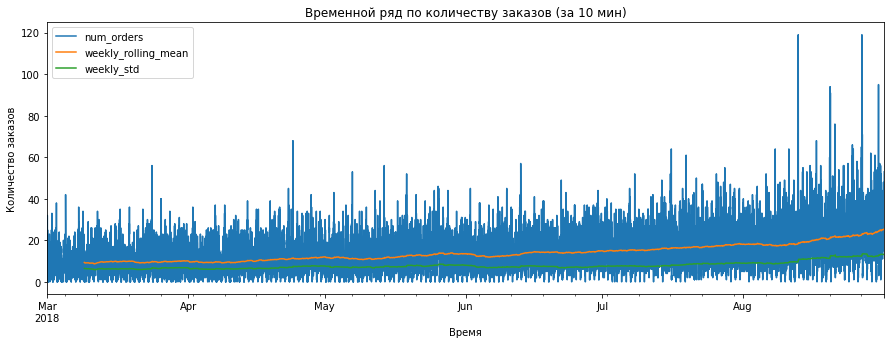

In [11]:
#plt.figure(figsize=(15, 5))
data['weekly_rolling_mean'] = data.shift(1).rolling(1176).mean()
data['weekly_std'] = data['num_orders'].shift(1).rolling(1176).std() 
data.plot(figsize=(15, 5))
plt.title('Временной ряд по количеству заказов (за 10 мин)')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.show();


Видим, что дисперсия (и вероятно, среднее) со временем немного возрастает в августе. То есть, временной ряд нестационарный.

### Оценка станционарности (тест Дики-Фуллера)

Оценим, насколько верно предположение о нестационарности ряда с помощью теста Дики-Фуллера.
<br>Нулевая гипотеза: ряд не стационарен.
<br>Альтернативная гипотеза: ряд стационарен.

In [12]:
#Удалим уже ненужные колонки
data = data.drop(['weekly_rolling_mean','weekly_std'],axis=1)

In [13]:
test = adfuller(data['num_orders'])
print ('adf: ', test[0] )
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('Для p-value=5%: Есть единичные корни, ряд не стационарен')
else:
    print ('Для p-value=5%: Единичных корней нет, ряд стационарен')
if test[0]> test[4]['1%']: 
    print ('Для p-value=1%: Есть единичные корни, ряд не стационарен')
else:
    print ('Для p-value=1%: Единичных корней нет, ряд стационарен')

adf:  -12.548885000267546
p-value:  2.2286378815479297e-23
Critical values:  {'1%': -3.430597284562216, '5%': -2.861649292553069, '10%': -2.566828173184574}
Для p-value=5%: Единичных корней нет, ряд стационарен
Для p-value=1%: Единичных корней нет, ряд стационарен


Проведенный теcт подтвердил гипотезу о стационарности ряда (и опроверг исходные предположения, что ряд нестационарен), ряд стационарен при обоих уровнях значимости.

### Сезонность по дням часам и дням недели

Так как таблица данные только за один год, нет возможности оценить сезонность по временам года, то есть например, сравнить лето текущего года с летом прошлого года. Но мы можем сделать ресемплирование и посмотреть сезонность по часам, дням и месяцам.

Рассмотрим сезонность по дням недели для месяца март (с понедельника - 5го числа).

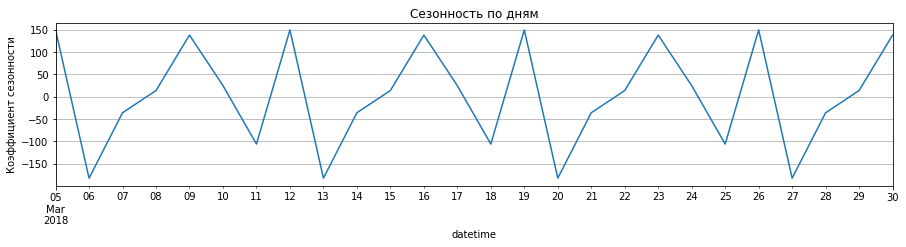

In [14]:
data_1d = data.resample('1D').sum()
data_1d['day_of_week'] = data_1d.index.dayofweek
decomposed = seasonal_decompose(data_1d['num_orders']) 
plt.figure(figsize=(15, 3))
decomposed.seasonal['2018-03-05':'2018-03-30'].plot(grid=True)
plt.title('Сезонность по дням')
plt.ylabel('Коэффициент сезонности')
plt.show()

Видим, что:
- наименьшее количество заказов во вторники (6,13числа) и воскресенья (11,18числа).
- наибольшее количество заказов в пятницу (9,16числа) и понедельник (12,19 числа).

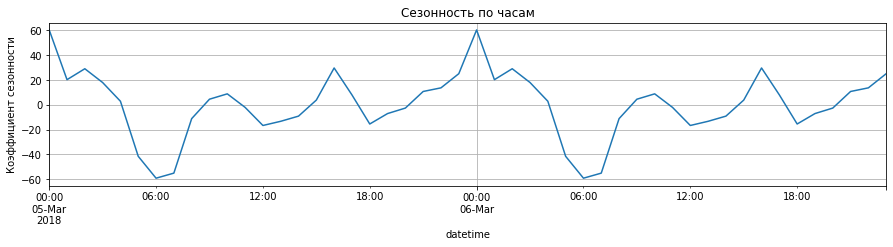

In [15]:
data_1h = data.resample('1H').sum()
data_1h['hour'] = data_1h.index.hour
decomposed = seasonal_decompose(data_1h['num_orders']) 
plt.figure(figsize=(15, 3))
decomposed.seasonal['2018-03-05':'2018-03-06'].plot(grid=True)
plt.title('Сезонность по часам');
plt.ylabel('Коэффициент сезонности')
plt.show()

Видим, что:
- часы максимальной нагрузки - c 21 до 4 утра (пик в 12 ночи), а также локальные пики в 10 утра и 16 часов
- часы минимальной нагрузки - после 4 утра (минимум в 6 утра), а также локальные минимумы в 12 и в 18 часов

Таким образом, существует часовая сезонность и дневная. 
<br> Обусловлено это, скорее всего тем, что в ночное время общественный транспорт ходит реже. Соответственно, люди чаще используют такси, чтобы добраться в аэропорт. Также, вероятно, в нерабочее время может быть больше рейсов (или, скажем, такие рейсы могут быть более популярны), соответственно, нагрузка на такси в аэропорт также увеличивается. 

**Вывод:**
- Среденее количество заказов - 14 заказов каждые 10 минут (т.к. данные предоставлены по 10минутным промежуткам), медиана примерно такая же - 13 заказов.
- Стандартное отклонение 9 и также по 25%- и 75% квантилям видим, что количество заказов в 10-минутные промежутки колебелется от 8 до 19. 
- Максимальное количество заказов - 119, оно наблюдалось 13августа в 2.20 ночи и 27августа в 2.10 ночи. Выглядит немного странно, если учесть ночное время в ночь на понедельник, но данное максимальное значение не сильно отличается от остальных выбросов (видим на боксплоте, что наблюдений с количеством заказов свыше 70 единичное количество), так что поверим данным.
- Дисперсия ряда со временем немного возрастает в августе. То есть, временной ряд нестационарный.
- Наименьшее количество заказов во вторники (6,13числа) и воскресенья (11,18числа)
- Наибольшее количество заказов в пятницу (9,16числа) и понедельник (12,19 числа)
- Часы максимальной нагрузки - c 21 до 4 утра (пик в 12 ночи), а также локальные пики в 10 утра и 16 часов
- Часы минимальной нагрузки - после 4 утра (минимум в 6 утра), а также локальные минимумы в 12 и в 18 часов
<br> Таким образом, существует часовая сезонность и дневная. <br> Обусловлено это, скорее всего тем, что в ночное время общественный транспорт ходит реже. Соответственно, люди чаще используют такси, чтобы добраться в аэропорт. Также, вероятно, в нерабочее время может быть больше рейсов (или, скажем, такие рейсы могут быть более популярны), соответственно, нагрузка на такси в аэропорт также увеличивается. 

## Обучение

### Добавление признаков

Так как для дальнейшего моделирования будем использовать набор, ресемплированный по 1часу (data_1h), то удалим ненужные датафреймы (data, data_1d).

In [16]:
del data, data_1d

Добавим признаки:
- Календарные:
    - месяц
    - день недели
    - час уже есть в выборке
- Отстающие значения: лаги на 1-5 значений
- Скользящее среднее на 2-5 значений

In [17]:
# Календарные признаки
data_1h['dayofweek'] = data_1h.index.dayofweek

In [18]:
lags = [1,2,3,4,5,24,168]

for lag in lags:
        data_1h['lag_{}'.format(lag)] = data_1h['num_orders'].shift(lag)
        data_1h['rolling_mean_{}'.format(lag)]=data_1h['num_orders'].shift(1).rolling(lag).mean()


In [19]:
data_1h.head(2)

,num_orders,hour,dayofweek,lag_1,rolling_mean_1,lag_2,rolling_mean_2,lag_3,rolling_mean_3,lag_4,rolling_mean_4,lag_5,rolling_mean_5,lag_24,rolling_mean_24,lag_168,rolling_mean_168
datetime,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Создание подвыборок

Создадим тестовую подвыборку 10% от общего набора.

In [20]:
train_valid, test = train_test_split(data_1h, test_size=0.1, random_state=RANDOM_STATE,shuffle=False)
print('Исходный набор:',data_1h.shape,data_1h.index.min(),'-',data_1h.index.max() )
print('Train+Valid:',train_valid.shape,train_valid.index.min(),'-',train_valid.index.max())
print('Test',test.shape,test.index.min(),'-',test.index.max())

Исходный набор: (4416, 17) 2018-03-01 00:00:00 - 2018-08-31 23:00:00
Train+Valid: (3974, 17) 2018-03-01 00:00:00 - 2018-08-13 13:00:00
Test (442, 17) 2018-08-13 14:00:00 - 2018-08-31 23:00:00


Данные разделились корректно.

Отделим от набора train_valid валидационную подвыборку в соотношении 9:1 (также как с тестовой выборкой).

In [21]:
train, valid = train_test_split(train_valid, test_size=0.1, random_state=RANDOM_STATE,shuffle=False)
print('Train:',train.shape,train.index.min(),'-',train.index.max())
print('Valid:',valid.shape,valid.index.min(),'-',valid.index.max())

Train: (3576, 17) 2018-03-01 00:00:00 - 2018-07-27 23:00:00
Valid: (398, 17) 2018-07-28 00:00:00 - 2018-08-13 13:00:00


Данные также разделились корректно.

In [22]:
train_valid = train_valid.dropna()

In [23]:
features_test = test.drop('num_orders',axis=1)
target_test = test['num_orders']
print('features_test:',features_test.shape)
print('target_test:',target_test.shape)
print()
print('Наборы для кроссвалидации и обучения перед финальным тестированием:')
features_trainvalid = train_valid.drop('num_orders',axis=1)
target_trainvalid = train_valid['num_orders']
print('features_trainvalid:',features_trainvalid.shape)
print('target_trainvalid:',target_trainvalid.shape)

features_test: (442, 16)
target_test: (442,)

Наборы для кроссвалидации и обучения перед финальным тестированием:
features_trainvalid: (3806, 16)
target_trainvalid: (3806,)


In [24]:
features_trainvalid.head(3)

,hour,dayofweek,lag_1,rolling_mean_1,lag_2,rolling_mean_2,lag_3,rolling_mean_3,lag_4,rolling_mean_4,lag_5,rolling_mean_5,lag_24,rolling_mean_24,lag_168,rolling_mean_168
datetime,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,0,3,94.0,94.0,127.0,110.5,108.0,109.666667,76.0,101.25,50.0,91.0,100.0,60.041667,124.0,54.226190
2018-03-08 01:00:00,1,3,143.0,143.0,94.0,118.5,127.0,121.333333,108.0,118.00,76.0,109.6,121.0,61.833333,85.0,54.339286
2018-03-08 02:00:00,2,3,78.0,78.0,143.0,110.5,94.0,105.000000,127.0,110.50,108.0,110.0,24.0,60.041667,71.0,54.297619


### Масштабирование признаков

In [25]:
numeric = ['dayofweek','lag_1', 'lag_2', 'lag_3', 'lag_4','lag_5','lag_24','lag_168','rolling_mean_2',\
          'rolling_mean_3','rolling_mean_4','rolling_mean_5','rolling_mean_24','rolling_mean_168']

scaler = StandardScaler()
scaler.fit(features_trainvalid[numeric])
features_trainvalid[numeric] = scaler.transform(features_trainvalid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
(print(features_trainvalid.head(5)))
(print(features_test.head(5)))

                     hour  dayofweek     lag_1  rolling_mean_1     lag_2  \
datetime                                                                   
2018-03-08 00:00:00     0  -0.013391  0.378907            94.0  1.231736   
2018-03-08 01:00:00     1  -0.013391  1.645921           143.0  0.378599   
2018-03-08 02:00:00     2  -0.013391 -0.034812            78.0  1.645378   
2018-03-08 03:00:00     3  -0.013391 -0.370958            65.0 -0.035043   
2018-03-08 04:00:00     4  -0.013391 -0.293386            68.0 -0.371127   

                     rolling_mean_2     lag_3  rolling_mean_3     lag_4  \
datetime                                                                  
2018-03-08 00:00:00        0.912430  0.740999        0.960649 -0.086030   
2018-03-08 01:00:00        1.146768  1.232344        1.330323  0.741925   
2018-03-08 02:00:00        0.912430  0.378955        0.812779  1.233524   
2018-03-08 03:00:00       -0.229971  1.646108        0.506477  0.379695   
2018-03-08 04:00:

Масштабирование проведено.

### Линейная регрессия CV

In [30]:
tscv = TimeSeriesSplit(n_splits=6)

def get_rmse (target,predict):
    return mean_squared_error(target, predict)**0.5

scorer = make_scorer(get_rmse, greater_is_better=False)

In [31]:
model_linreg_cv = LinearRegression() 
params_grid = { }

In [32]:
msearch = GridSearchCV(model_linreg_cv, params_grid, scoring=scorer, cv=tscv)
msearch.fit(features_trainvalid, target_trainvalid)
rmse_linear_valid = abs(msearch.best_score_)
print('RMSE линейной регрессии с кроссвалидацией:',rmse_linear_valid)

RMSE линейной регрессии с кроссвалидацией: 22.976083177110237


In [33]:
models_results = pd.DataFrame(columns=['model', 'RMSE_valid'])
row1 = pd.DataFrame({'model': ['LinearRegression'], 'RMSE_valid': [rmse_linear_valid]})

models_results = models_results.append(row1,ignore_index = True)

display(models_results.sort_values(by='RMSE_valid').style.background_gradient(cmap='Blues', axis=0,subset=['RMSE_valid']))

,model,RMSE_valid
0,LinearRegression,22.976083


### Дерево решений CV

In [35]:
model_tree_cv = DecisionTreeRegressor() 
params_grid = {#'criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
               'splitter':['best', 'random'],
               'max_depth': range(1,10),
               'random_state':[RANDOM_STATE],
               'max_features':['auto', 'sqrt', 'log2']
               }

In [36]:
msearch = GridSearchCV(model_tree_cv, params_grid, scoring=scorer, cv=tscv)
msearch.fit(features_trainvalid, target_trainvalid)

#print(msearch.best_estimator_)
#print(msearch.best_params_)
rmse_tree = abs(msearch.best_score_)
print('RMSE дерева решений с кроссвалидацией:',rmse_tree)

RMSE дерева решений с кроссвалидацией: 25.22679939714729


Дерево решений немного улучшило метрику - до 25 единиц. При этом глубина получилась небольшая - 4 уровня.

In [37]:
row1 = pd.DataFrame({'model': ['DecisionTreeRegressor'], 'RMSE_valid': [rmse_tree]})
models_results = models_results.append(row1,ignore_index = True)
display(models_results.sort_values(by='RMSE_valid').style.background_gradient(cmap='Blues', axis=0,subset=['RMSE_valid']))

,model,RMSE_valid
0,LinearRegression,22.976083
1,DecisionTreeRegressor,25.226799


Модель дерева выдала метрику чуть похуже и при этом работает немного дольше (хотя в данном случае доли секунд незаметны).

### Случайный лес CV

In [39]:
model_forest_cv = RandomForestRegressor() 
params_grid = {'max_depth': range(1,10),
               'n_estimators':range(10,100,10),
               'random_state':[RANDOM_STATE],
               'max_features':['auto', 'sqrt', 'log2']
               }
msearch_tree = GridSearchCV(model_forest_cv, params_grid, scoring=scorer, cv=tscv)
msearch_tree.fit(features_trainvalid, target_trainvalid)

#print(msearch_tree.best_estimator_)
print('Лучшие параметры:',msearch_tree.best_params_)
rmse_forest = abs(msearch_tree.best_score_)
print('RMSE случайного леса с кроссвалидацией:',rmse_forest)

Лучшие параметры: {'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 90, 'random_state': 12345}
RMSE случайного леса с кроссвалидацией: 22.849667548650615


Случайный лес еще немного улучшил метрику - до 22,8.

In [40]:
row1 = pd.DataFrame({'model': ['RandomForestRegressor'], 'RMSE_valid': [rmse_forest]})
models_results = models_results.append(row1,ignore_index = True)
display(models_results.sort_values(by='RMSE_valid').style.background_gradient(cmap='Blues', axis=0,subset=['RMSE_valid']))

,model,RMSE_valid
2,RandomForestRegressor,22.849668
0,LinearRegression,22.976083
1,DecisionTreeRegressor,25.226799


Модель получилась на сотые доли rmse лучше, чем линейная регрессия.

**Вывод:**
<br> В набор данных были добавлены следующие признаки признаки:
- Календарные:
    - месяц
    - день недели
    - час был добавлен ранее
- Отстающие значения: лаги на 1-5 значений
- Скользящее среднее на 2-5 значений

<br>Разделение на обучающую и тестовую подвыборки проведено в соотношении 9:1:
- Исходный набор: (4416, 13) 2018-03-01 00:00:00 - 2018-08-31 23:00:00
- Train: (3974, 13) 2018-03-01 00:00:00 - 2018-08-13 13:00:00
- Test (442, 13) 2018-08-13 14:00:00 - 2018-08-31 23:00:00
<br>Также были добавены набор trainvalid, который использвался при кроссвалидации в линейной регрессии.

<br>Были опробованы модели:
- модель линейной регрессии с кроссвалидацией
- модель дерева решений с кроссвалидацией
- модель случайного леса с кроссвалидацией

Модели показали следующие результаты:

In [44]:
display(models_results.sort_values(by='RMSE_valid').style.background_gradient(cmap='Blues', axis=0,subset=['RMSE_valid']))

,model,RMSE_valid
2,RandomForestRegressor,22.849668
0,LinearRegression,22.976083
1,DecisionTreeRegressor,25.226799


Как видим, лучший результат у модели случайного леса.
Возьмем в эту модель с наилучшими найденными параметрами качестве финальной модели.

## Тестирование

### Модель случайного леса на тестовой выборке

In [47]:
model = msearch_tree.best_estimator_ # инициализируйте модель RandomForestRegressor с параметрами random_state=12345, n_estimators=est и max_depth=depth
model.fit(features_trainvalid,target_trainvalid) # обучите модель на тренировочной выборке
predictions_test = model.predict(features_test) # получите предсказания модели на валидационной выборке
rmse_result = (mean_squared_error(target_test,predictions_test))**0.5# посчитайте значение метрики rmse на валидационной выборке
print('RMSE модели случайного леса на тестовой выборке:',rmse_result )

RMSE модели случайного леса на тестовой выборке: 41.09119656378111


Построим график предсказаний модели в сравнении с фактическими данными.

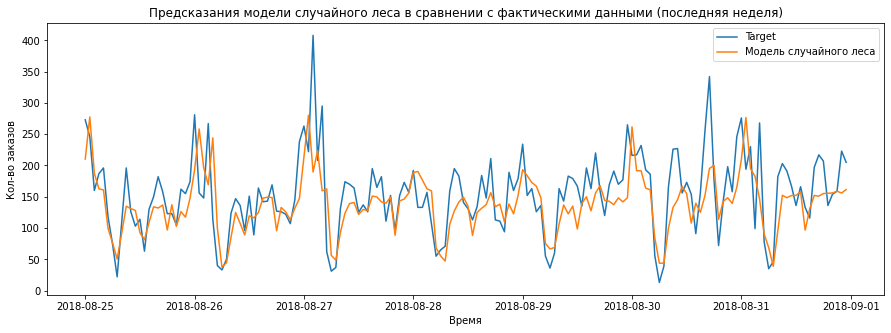

In [48]:
predictions_test = pd.Series(predictions_test, index=features_test.index)
plt.figure(figsize=(15, 5))
plt.plot(target_test.tail(168), label='Target')
plt.plot(predictions_test.tail(168), label='Модель случайного леса')
plt.legend()
plt.title('Предсказания модели случайного леса в сравнении с фактическими данными (последняя неделя)')
plt.xlabel('Время')
plt.ylabel('Кол-во заказов')
plt.show();

На графике видно, что в целом модель неплохо угадывает общие тенденции графика, но все же ошибается в детальных колебаниях. Связано это, возможно, с авторегрессией и сезонностью временого ряда, которые модель леса плохо просчитывает.

### Проверка модели на адекватность.

Проверим модель на адекватность против дамми-модели и модели, которая предсказывает среднее.

In [51]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_trainvalid, target_trainvalid)
dummy_predict = dummy_regr.predict(features_test)
dummy_test_rmse = mean_squared_error(target_test,dummy_predict)**0.5
print('Оценка RMSE на модели dummy:',dummy_test_rmse)


Оценка RMSE на модели dummy: 83.97941361168559


In [52]:
avg_predict = pd.Series(target_trainvalid.mean(), index=features_test.index)
avg_test_rmse = mean_squared_error(target_test,avg_predict)**0.5
print('Оценка RMSE на модели dummy:',avg_test_rmse)

Оценка RMSE на модели dummy: 83.97941361168559


**Вывод:** Видим, что обе модели выдали результат хуже, чем модель линейной регрессии и экспоненциального сглаживания. Значит, выбранные модели рабочие.

### Анализ влияния признаков

Проверим, какие из признаков оказались наиболее важными при моделировании линейной регрессии.

lag_168             0.368180
lag_24              0.153744
hour                0.080724
lag_1               0.079972
rolling_mean_1      0.060696
rolling_mean_2      0.052053
rolling_mean_168    0.039338
rolling_mean_24     0.038693
rolling_mean_3      0.031057
rolling_mean_4      0.028857
rolling_mean_5      0.017203
lag_5               0.012632
lag_2               0.012597
lag_4               0.009974
lag_3               0.009960
dayofweek           0.004319
dtype: float64


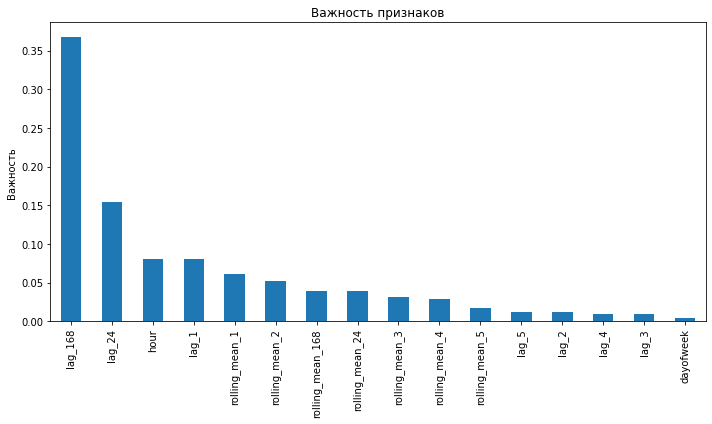

In [53]:
model = msearch_tree.best_estimator_
model.fit(features_trainvalid, target_trainvalid)

feature_importance = pd.Series(model.feature_importances_,
                         features_trainvalid.columns).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10,6))
feature_importance.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
fig.tight_layout()

print(feature_importance)

Наиболее важными оказались признаки:
- lag_168 - спрос на такси в аналогичный день и час на прошлой неделе.
- lag_24 - в аналогичный час предыдущего дня
- hour - значение текущего часа
- lag_1 - спрос на такси в предыдущий час

Наименее важные признаки: день недели и спрос на такси в предыдущие 2-5 часов.


## Вывод

In [ ]:
display(models_results.sort_values(by='RMSE_valid').style.background_gradient(cmap='Blues', axis=0,subset=['RMSE_valid']))

Как видим, лучший результат у модели случайного леса с кроссвалидацией (и очень близкий результат у линейной регрессии с кроссвалидацией).
<br>В качестве финальной модели была выбрана модель случайного леса.
<br>**Модель случайного леса на тестовой выборке показала результат RMSE = 41,1**

**Анализ адекватности модели:**
Анализ адекватности показал, что dummy-модель и модель, предсказывающая среднее, работают гораздо хуже случайного леса, а значит, выбранная модель действительно помогает в предсказании заказов такси.

**Анализ важности признаков:**
Наиболее важными оказались признаки:
- lag_168 - спрос на такси в аналогичный день и час на прошлой неделе.
- lag_24 - в аналогичный час предыдущего дня
- hour - значение текущего часа
- lag_1 - спрос на такси в предыдущий час

Наименее важные признаки: день недели и спрос на такси в предыдущие 2-5 часов.